In [11]:
# @title
!git clone --quiet https://github.com/GabrielMissael/super-resolution-workshop

In [12]:
import sys
sys.path.append("super-resolution-workshop/src")

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from ipywidgets import interact, FloatSlider, IntSlider

from enhance import unsharp_mask_color, denoise_color, adjust_saturation, adjust_contrast_brightness
from debayer import debayer_stack
from trim_jupiter_images import get_frames
from quality_and_align import compute_quality_scores, choose_reference_frame, detect_ref_points, align_frames
from visualize_results import overlay_points

data = get_frames("super-resolution-workshop/data/jupiter_frames.avi")
print(f"Data loaded successfully!")

Data loaded successfully!


In [13]:
# @title
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(data[0], cmap="gray")
ax.axis("off")
plt.tight_layout()


def animate(i):
    im.set_data(data[i])
    return [im]


ani = animation.FuncAnimation(fig, animate, frames=60,
                              interval=1000.0 / 30, blit=True)
html_video = HTML(ani.to_html5_video())
plt.close(fig)
html_video

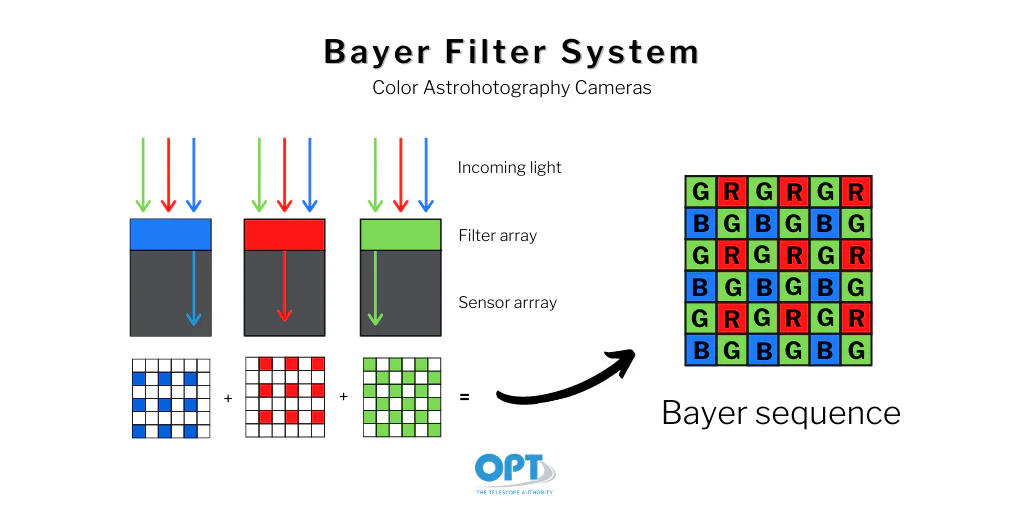


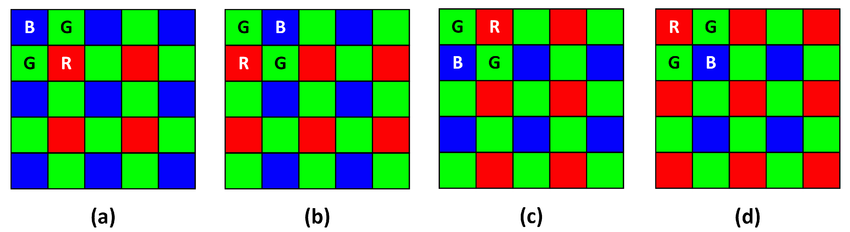

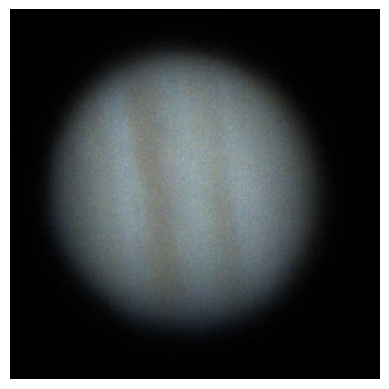

In [14]:
pattern = "GRBG" #@param ['RGGB', 'GRBG', 'GBRG', 'BGGR'] {'type':'string'}
method = "VNG" #@param ['VNG', 'Bilinear', 'EA'] {'type':'string'}


deb_frames = debayer_stack(data, pattern=pattern, method=method)
plt.imshow(deb_frames[0])
plt.axis("off")
plt.show()

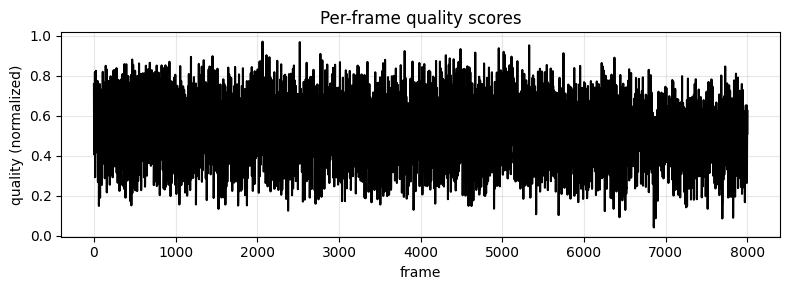

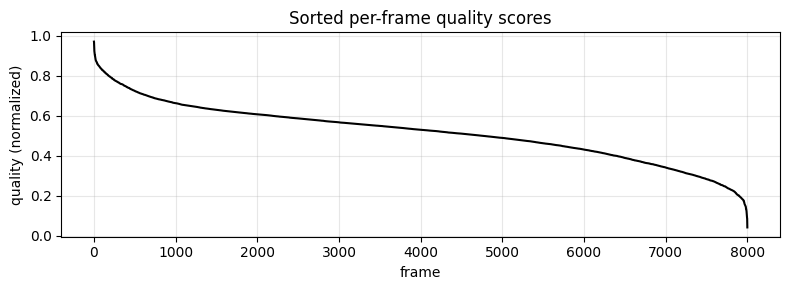

In [15]:
# @title
# scores, _, _ = compute_quality_scores(deb_frames)
scores = np.load("super-resolution-workshop/data/scores.npz")["arr_0"]

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(scores, '-k')
ax.set_xlabel('frame')
ax.set_ylabel('quality (normalized)')
ax.set_title('Per-frame quality scores')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(np.sort(scores)[::-1], '-k')
ax.set_xlabel('frame')
ax.set_ylabel('quality (normalized)')
ax.set_title('Sorted per-frame quality scores')
ax.grid(alpha=0.3)
fig.tight_layout()
plt.show()

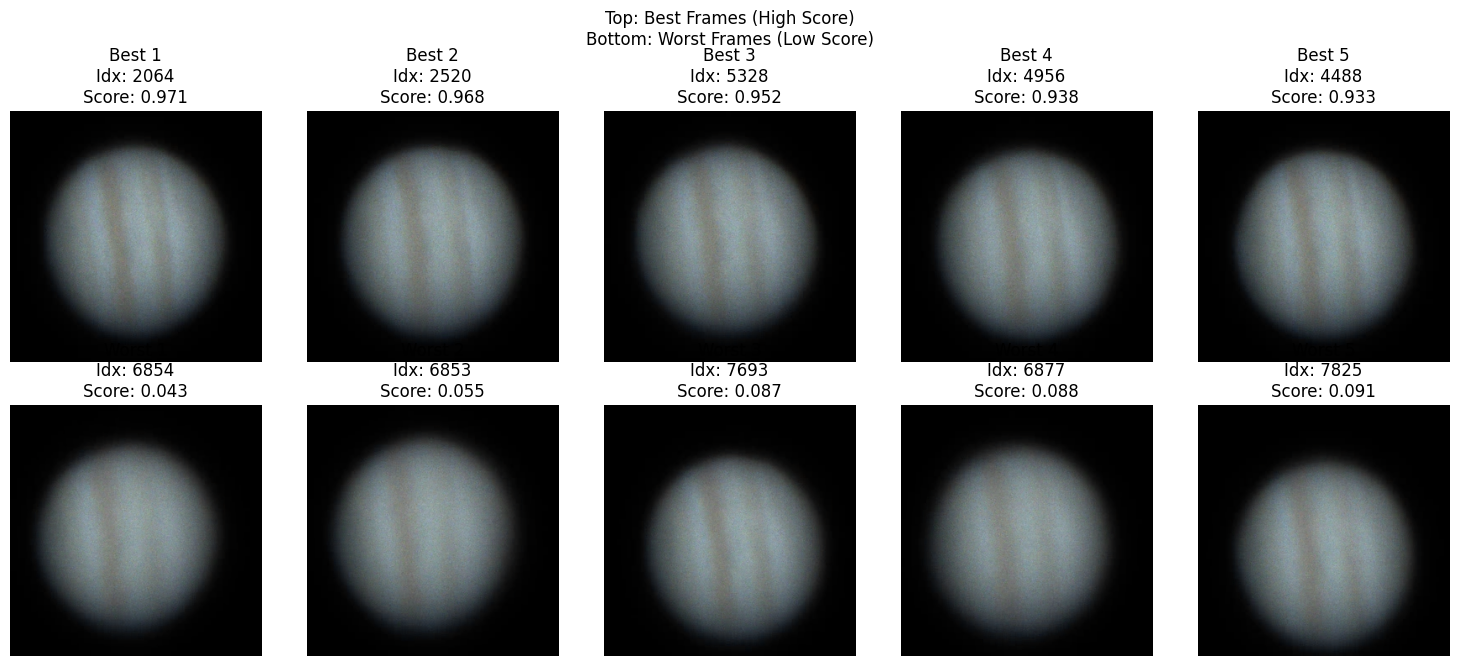

In [16]:
num_images = 5 # @param {'type':'integer'}
N = num_images

sorted_indices = np.argsort(scores)
worst_indices = sorted_indices[:N]
best_indices = sorted_indices[-N:][::-1]

fig, axs = plt.subplots(2, N, figsize=(3 * N, 6.75))

for i in range(N):
    idx = best_indices[i]
    axs[0, i].imshow(deb_frames[idx])
    axs[0, i].set_title(f"Best {i + 1}\nIdx: {idx}\nScore: {scores[idx]:.3f}")
    axs[0, i].axis('off')

    idx = worst_indices[i]
    axs[1, i].imshow(deb_frames[idx])
    axs[1, i].set_title(f"Worst {i + 1}\nIdx: {idx}\nScore: {scores[idx]:.3f}")
    axs[1, i].axis('off')

plt.suptitle("Top: Best Frames (High Score)\nBottom: Worst Frames (Low Score)")
plt.tight_layout()
plt.show()

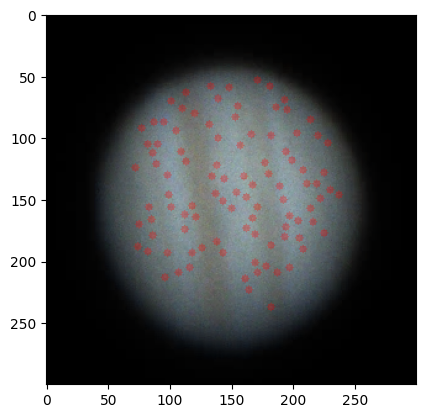

In [17]:
reference_idx = choose_reference_frame(scores)
reference_frame = deb_frames[reference_idx]

n_ref_points = 100
ref_pts = detect_ref_points(reference_frame, max_corners=n_ref_points)

image = overlay_points(reference_frame, ref_pts, (1, 0, 0), alpha=0.3)
plt.imshow(image)
plt.show()

In [18]:
idx_to_align = sorted_indices[-10:][::-1]
reference_idx = 0

aligned, transforms = align_frames(deb_frames[idx_to_align], reference_idx, ref_pts)

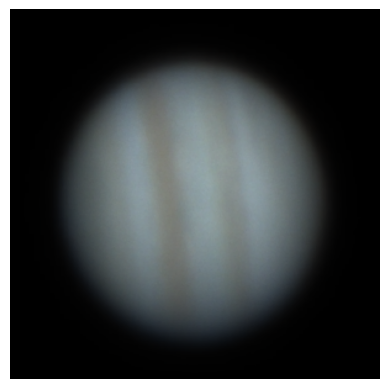

In [19]:
plt.imshow(aligned.sum(0) // len(idx_to_align))
plt.axis("off")
plt.show()

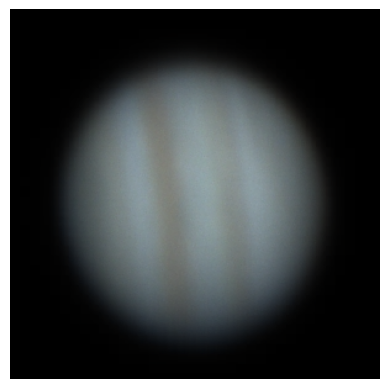

In [20]:
plt.imshow(deb_frames[idx_to_align].sum(0) // len(idx_to_align))
plt.axis("off")
plt.show()

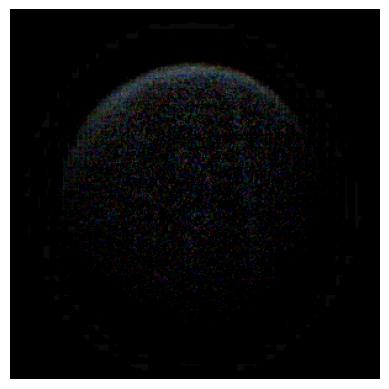

In [21]:
diff = aligned.sum(0).astype(np.int32) // len(idx_to_align) - deb_frames[idx_to_align].sum(0).astype(np.int32) // len(
        idx_to_align)

plt.imshow(np.clip(diff * 10, 0, 255))
plt.axis("off")
plt.show()

In [22]:
img = (aligned.sum(0) // aligned.shape[0]).astype(np.uint8)

result = {'unsharp': None}

def adjust_unsharp(sigma=2.0, amount=1.0, threshold=0):
    out = unsharp_mask_color(img, sigma=sigma, amount=amount, threshold=threshold)
    result['unsharp'] = out
    plt.figure(figsize=(6, 6))
    plt.imshow(out)
    plt.axis('off')
    plt.show()

interact(
    adjust_unsharp,
    sigma=FloatSlider(value=2.0, min=0.1, max=10.0, step=0.1),
    amount=FloatSlider(value=1.0, min=0.0, max=5.0, step=0.1),
    threshold=IntSlider(value=0, min=0, max=10, step=1)
)

interactive(children=(FloatSlider(value=2.0, description='sigma', max=10.0, min=0.1), FloatSlider(value=1.0, d…

<function __main__.adjust_unsharp(sigma=2.0, amount=1.0, threshold=0)>

In [26]:
def adjust_denoise(h=0, hColor=0):
    out = denoise_color(result["unsharp"], h=h, hColor=hColor)
    result['denoised'] = out
    plt.figure(figsize=(6, 6))
    plt.imshow(out)
    plt.axis('off')
    plt.show()

interact(
    adjust_denoise,
    h=FloatSlider(value=0.0, min=0.0, max=5.0, step=0.05),
    hColor=FloatSlider(value=0.0, min=0.0, max=50.0, step=0.05),
)

interactive(children=(FloatSlider(value=0.0, description='h', max=5.0, step=0.05), FloatSlider(value=0.0, desc…

<function __main__.adjust_denoise(h=0, hColor=0)>

In [25]:
def adjust_saturation_plot(factor=1.0, contrast=1.0, brightness=1.0):
    out = adjust_saturation(result["denoised"], factor=factor)
    out = adjust_contrast_brightness(out, contrast=contrast, brightness=brightness)
    result['saturation'] = out
    plt.figure(figsize=(6, 6))
    plt.imshow(out)
    plt.axis('off')
    plt.show()

interact(
    adjust_saturation_plot,
    factor=FloatSlider(value=1.0, min=0.1, max=3.0, step=0.05),
    contrast=FloatSlider(value=1.0, min=0.1, max=2.0, step=0.02),
    brightness=FloatSlider(value=0.0, min=-100, max=100, step=0.5),
)

interactive(children=(FloatSlider(value=1.0, description='factor', max=3.0, min=0.1, step=0.05), FloatSlider(v…

<function __main__.adjust_saturation_plot(factor=1.0, contrast=1.0, brightness=1.0)>